In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas_datareader as web
import math
import yfinance as yf
import pandas as pd
import seaborn as sns

# Lecture des informations finance depuis Yahoo

In [2]:
etf = ['BZ=F','EURUSD=X','TTF=F','TTFX23.NYM','TTFZ23.NYM','TTFV23.NYM']
#data = yf.Ticker(etf)
#dataH = data.history(start='2007-01-01',period='1d')
it = yf.download(tickers=etf, period='1d',start='2012-01-01')
it = it.rename(columns = {'TTFU23.NYM':'SEP23', 'TTFX23.NYM':'NOV23','TTFV23.NYM':'OCT23', 'TTFZ23.NYM':'DEC23', 'EURUSD=X':'€/$'})

[*********************100%***********************]  6 of 6 completed


# Lecture des informations de stock de Gaz depuis AGSI
* normalisation des données
* conversion en float
* conversion des dates

pour un Pays remplacer "type" par "country" et mettre en paramètre le code du pays : FR, BE, DE ...

In [3]:
import requests
params = {
    "type": "EU",
    "from": "2012-01-01",
    "size": 10000
}
header = {
  "x-key" : "99e18f932d22c9acf9c42f27d0b8b539" }

url = "https://agsi.gie.eu/api"
resp = requests.get(url=url, params=params, headers=header)
json = resp.json()
data = pd.json_normalize(json['data'])
data["gasInStorage"] = data["gasInStorage"].astype(float)
#data["coveredCapacity"] = data["coveredCapacity"].astype(float)
pd.to_datetime(data['gasDayStart'], errors='coerce')
#data[["gasDayStart","gasInStorage"]]
#print(data)
print('Done')

Done


### Préparation des données (en mois / années)

In [4]:
import datetime as dt
endData = data[["gasDayStart","gasInStorage"]].copy(deep = True)
endData['Date'] = pd.to_datetime(endData['gasDayStart'],format='%Y-%m-%d', errors='coerce',utc=False)
endData['année'] = endData['Date'].dt.year
endData['mois'] = endData['Date'].dt.month
endData.set_index('Date')

,gasDayStart,gasInStorage,année,mois
Date,,,,
2023-09-29,2023-09-29,1096.6759,2023,9
2023-09-28,2023-09-28,1086.9474,2023,9
2023-09-27,2023-09-27,1085.5745,2023,9
2023-09-26,2023-09-26,1084.0975,2023,9
2023-09-25,2023-09-25,1082.9756,2023,9
...,...,...,...,...
2012-01-05,2012-01-05,547.8834,2012,1
2012-01-04,2012-01-04,550.0136,2012,1
2012-01-03,2012-01-03,552.2452,2012,1


In [5]:
def filtreAnnee(df, a):
    mask_ = (df['année'] == a)
    #mask_ = ((fin['mois'] == 2) & (fin['year'] == 2022))
    return df.loc[mask_]

              gasInStorage     TTF=F      BZ=F     OCT23     NOV23     DEC23
gasInStorage      1.000000 -0.158373  0.516336 -0.273694 -0.221505 -0.130477
TTF=F            -0.158373  1.000000  0.218888  0.977878  0.945515  0.922013
BZ=F              0.516336  0.218888  1.000000  0.072382  0.040376  0.072951
OCT23            -0.273694  0.977878  0.072382  1.000000  0.982852  0.956502
NOV23            -0.221505  0.945515  0.040376  0.982852  1.000000  0.991891
DEC23            -0.130477  0.922013  0.072951  0.956502  0.991891  1.000000


<AxesSubplot:>

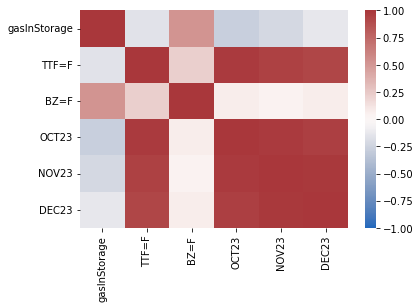

In [6]:
final = pd.merge(endData, it['Close'], how='left', on="Date" )
fin =final.dropna()
# mask_ = (fin['année'] == 2023)
# #mask_ = ((fin['mois'] == 2) & (fin['year'] == 2022))
# fin_ = fin.loc[mask_]
fin_ = filtreAnnee(fin, 2023)
fin_ = (fin_[["gasInStorage","TTF=F","BZ=F","OCT23","NOV23","DEC23","Date"]])
fin_ = fin_.set_index("Date")
print(fin_.corr())
sns.heatmap(fin_.corr(),cmap='vlag', vmin=-1, vmax=1)

Stock maxi sur la période :  1086.9474


<AxesSubplot:xlabel='Date'>

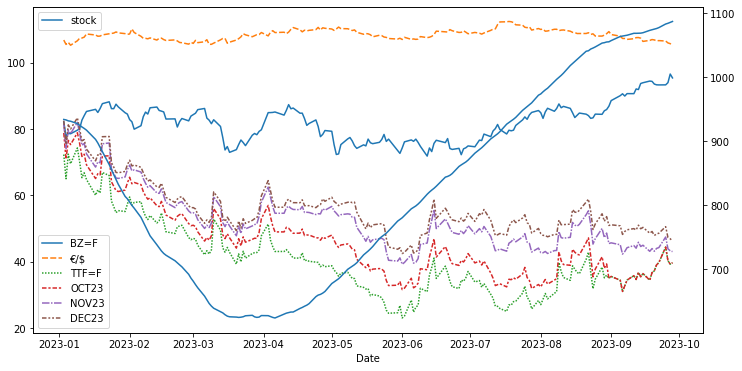

In [7]:
# On fait une copie du DF et on remet les index
# cette copy est filtrée suivant l'année
an = 2023
fin_1 = filtreAnnee(fin,an).copy(deep=True)
fin_2 = filtreAnnee(fin[['gasInStorage','Date','année']],an).copy(deep=True)
fin_1 = fin_1.set_index("Date")
fin_2 = fin_2.set_index("Date")
# On normalise si besoin 
maxi = fin_1["gasInStorage"].max()
print('Stock maxi sur la période : ',maxi)
maxi = 100.0 # si on ne souhaite pas normaliser
# on normalise le stock (100%) et on nettoye ...
fin_2["stock"] = fin_2["gasInStorage"] / maxi * 100.0
# print(fin_1.head())
fin_1['€/$'] = fin_1['€/$'] * 100.0
fin_1 = fin_1.drop(['année','mois','gasDayStart','gasInStorage'], axis=1)
fin_2 = fin_2.drop(['gasInStorage','année'],axis=1)
# on Affiche le graphique
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=fin_1, color='Blue')
ax2 = plt.twinx()
sns.lineplot(data=fin_2, ax=ax2 , color='red')

In [8]:
fin[0:16]

,gasDayStart,gasInStorage,Date,année,mois,BZ=F,€/$,TTF=F,OCT23,NOV23,DEC23
1,2023-09-28,1086.9474,2023-09-28,2023,9,95.379997,1.050531,39.736000,39.736000,43.089001,46.312000
2,2023-09-27,1085.5745,2023-09-27,2023,9,96.550003,1.056948,39.296001,39.296001,43.319000,46.944000
3,2023-09-26,1084.0975,2023-09-26,2023,9,93.959999,1.059165,40.321999,40.321999,43.917000,47.331001
4,2023-09-25,1082.9756,2023-09-25,2023,9,93.290001,1.064849,44.442001,44.442001,47.481998,50.602001
7,2023-09-22,1077.3416,2023-09-22,2023,9,93.269997,1.066155,39.791000,39.791000,44.292999,48.631001
8,2023-09-21,1075.9540,2023-09-21,2023,9,93.300003,1.065303,39.105000,39.105000,44.053001,48.375999
9,2023-09-20,1074.9846,2023-09-20,2023,9,93.529999,1.068205,37.284000,37.284000,43.191002,47.953999
10,2023-09-19,1074.0711,2023-09-19,2023,9,94.339996,1.069267,36.782001,36.782001,44.004002,49.146999
11,2023-09-18,1073.0598,2023-09-18,2023,9,94.430000,1.066826,34.474998,34.474998,43.167999,48.631001
14,2023-09-15,1069.3627,2023-09-15,2023,9,93.930000,1.063717,36.483002,36.483002,45.006001,50.379002


              gasInStorage     TTF=F      BZ=F     OCT23     NOV23     DEC23
gasInStorage      1.000000  0.006476 -0.235818  0.147001  0.159188  0.166241
TTF=F             0.006476  1.000000  0.690667  0.904632  0.895897  0.891360
BZ=F             -0.235818  0.690667  1.000000  0.596047  0.602405  0.604162
OCT23             0.147001  0.904632  0.596047  1.000000  0.998389  0.996545
NOV23             0.159188  0.895897  0.602405  0.998389  1.000000  0.999623
DEC23             0.166241  0.891360  0.604162  0.996545  0.999623  1.000000


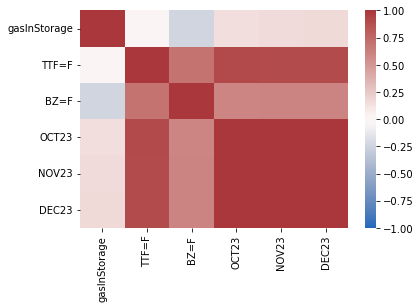

In [9]:
fin_ = fin[["gasInStorage","TTF=F","BZ=F","OCT23","NOV23","DEC23","Date"]]
fin_ = fin_.set_index('Date')
sns.heatmap(fin_.corr(), vmin=-1, vmax=1, cmap='vlag')
print(fin_.corr())